RDKit WARNING: [17:02:43] Enabling RDKit 2019.09.3 jupyter extensions


,R1,R2,R3,P1,P2,P3,P4,P5,ID_kida,Reaction_Energy(kJ/mol)_Woon,Reaction_Energy(kJ/mol)_xtb,Reaction_Image,diff,diff_norm
0,C2_0,H1C1N1_0,NaN,H1_0,C3N1_6,NaN,NaN,NaN,0,5.860120,149.312272,reaction_0,143.452153,3.032200
1,C2_0,H1C1N1_1,NaN,H1_0,C3N1_6,NaN,NaN,NaN,0,-56.251375,65.540833,reaction_1,121.792208,2.574366
2,O1_0,H2C1_0,NaN,H1_0,H1C1O1_0,NaN,NaN,NaN,1,-362.802332,-660.931495,reaction_2,-298.129163,-6.301664
3,O1_0,H2C1_0,NaN,C1O1_0,H2_0,NaN,NaN,NaN,2,-737.881509,-965.221492,reaction_3,-227.339983,-4.805368
4,O1_0,H2C1_0,NaN,C1O1_0,H1_0,H1_0,NaN,NaN,3,-283.627701,-451.358396,reaction_4,-167.730695,-3.545384
5,O1_0,H1C1O1_0,NaN,H1_0,C1O2_1,NaN,NaN,NaN,4,-457.580319,-885.735974,reaction_5,-428.155655,-9.050081
6,O1_0,H1C1O1_0,NaN,C1O1_0,H1O1_0,NaN,NaN,NaN,5,-371.429730,-487.421353,reaction_6,-115.991623,-2.451757
7,O1_0,H1C1N1_0,NaN,C1O1_0,H1N1_0,NaN,NaN,NaN,6,-136.100759,-138.480647,reaction_7,-2.379888,-0.050305
8,O1_0,H1C1N1_1,NaN,C1O1_0,H1N1_0,NaN,NaN,NaN,6,-198.212253,-222.252086,reaction_8,-24.039833,-0.508139
9,O1_0,H1C1N1_0,NaN,C1N1_0,H1O1_0,NaN,NaN,NaN,7,99.629914,-133.536547,reaction_9,-233.166461,-4.928524


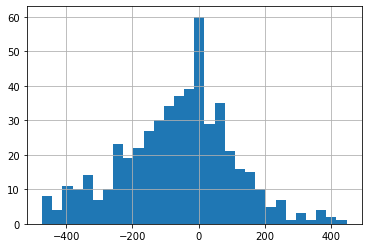

In [1]:
import os
import pandas as pd
import numpy as np
from mol_lib import xtb_isomers, FromXtbToSpinM, FromFormulaToAtomsList, FromFormulaToElectronCore, FromFormulaToElectron, FromNetworkDataFrameToNetworkClassList
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
from matplotlib import cm

with open("/Users/tinaccil/Documents/GitHub/woon_query/data_analysis/dataframe/molecules_info.csv","r") as data:
	df_mol = pd.read_csv(data, delimiter = '\t')
with open("/Users/tinaccil/Documents/GitHub/woon_query/data_analysis/dataframe/network.csv","r") as data:
	df_net = pd.read_csv(data, delimiter = '\t')

df_net['diff'] = df_net['Reaction_Energy(kJ/mol)_xtb'] - df_net['Reaction_Energy(kJ/mol)_Woon']
df_net['diff'].hist(bins=30)
max_val = df_net['diff'].abs().max()
df_net['diff_norm'] = df_net['diff'].apply(lambda x: x / max_val * 10)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_net)

In [2]:
df_mol_t = df_mol.copy()
df_mol_t = df_mol_t.drop(columns={'Na','Mass','state_woon','multiplicity_woon','energy(kJ/mol)_woon','spin_input_xtb','multiplicity_xtb','energy(kJ/mol)_xtb','pwd_xyz_woon','pwd_xyz_xtb'})

for index, rows in df_net.iterrows():
    tmp_n = rows.Reaction_Image
    df_mol_t[tmp_n] = 0
    df_mol_t.loc[df_mol_t['ID'] == rows.R1, tmp_n] = df_mol_t[tmp_n].loc[df_mol_t['ID'] == rows.R1] + 1
    df_mol_t.loc[df_mol_t['ID'] == rows.R2, tmp_n] = df_mol_t[tmp_n].loc[df_mol_t['ID'] == rows.R2] + 1
    df_mol_t.loc[df_mol_t['ID'] == rows.P1, tmp_n] = df_mol_t[tmp_n].loc[df_mol_t['ID'] == rows.P1] + 1
    df_mol_t.loc[df_mol_t['ID'] == rows.P2, tmp_n] = df_mol_t[tmp_n].loc[df_mol_t['ID'] == rows.P2] + 1
    df_mol_t.loc[df_mol_t['ID'] == rows.P3, tmp_n] = df_mol_t[tmp_n].loc[df_mol_t['ID'] == rows.P3] + 1

df_mol_tp = df_mol_t.copy()
df_mol_tp = df_mol_tp.drop(columns={'formula','ID'})
df_mol_tp = df_mol_tp.T
df_mol_tp.columns = df_mol_tp.iloc[0]
df_mol_tp = df_mol_tp.drop(df_mol_tp.index[0])
df_mol_tp['name'] = df_mol_tp.index

df_net_n = pd.merge(left=df_net, right=df_mol_tp, how='left', left_on='Reaction_Image', right_on='name')
df_net_n = df_net_n.drop(columns='name')

number of estimated clusters : 10


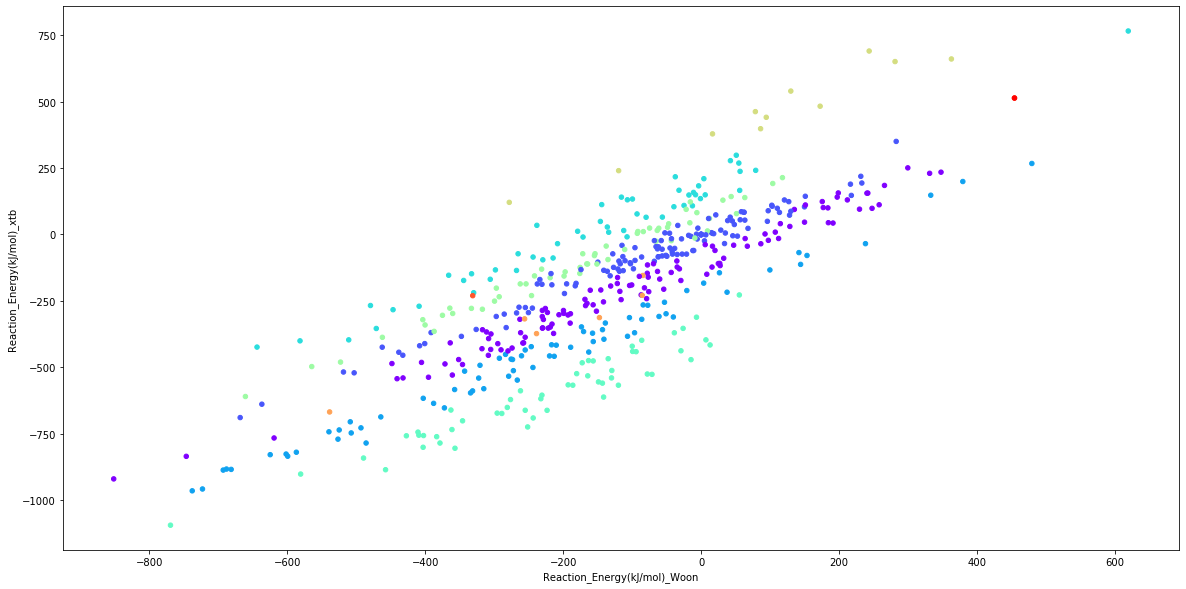

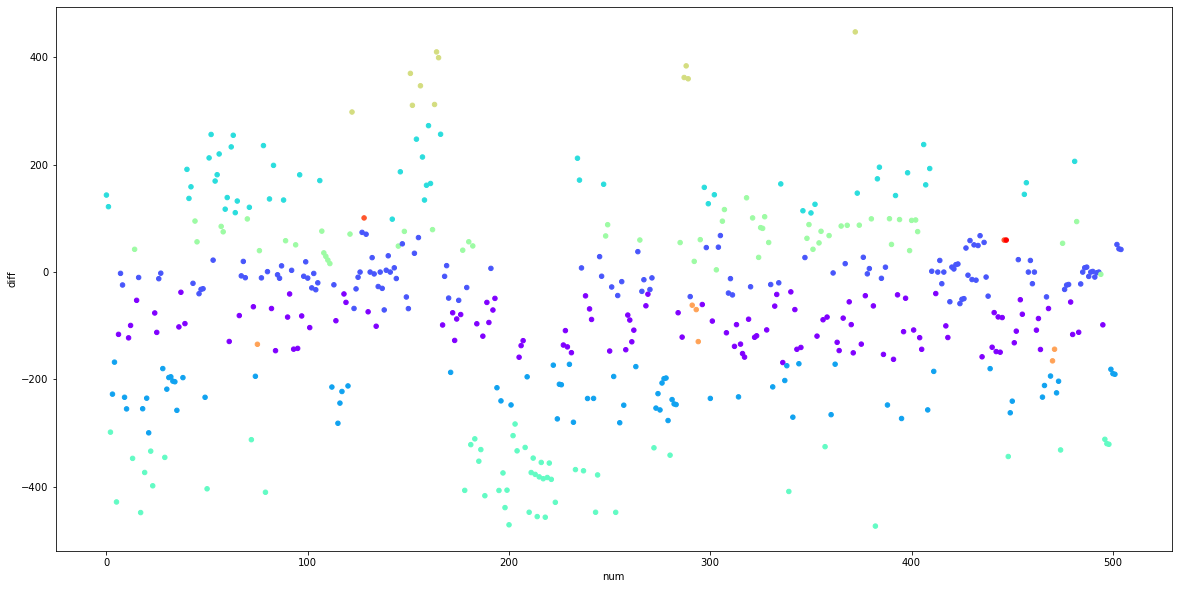

In [4]:
df_net_m = df_net_n.copy()
df_net_m = df_net_m.drop(columns={'R1','R2','R3','P1','P2','P3','P4','P5','ID_kida','Reaction_Energy(kJ/mol)_Woon','Reaction_Energy(kJ/mol)_xtb','Reaction_Image','diff'})

arr = df_net_m.to_numpy()

bandwidth = estimate_bandwidth(arr,quantile=0.01)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(arr)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

df_net['label'] = labels

print("number of estimated clusters : %d" % n_clusters_)


def FromLabelToColor(df,label):
    categories = np.unique(df[label])
    colors = cm.rainbow(np.linspace(0, 1, len(categories)))
    colordict = dict(zip(categories, colors))  
    df["Color"] = df[label].apply(lambda x: colordict[x])
    return(df)

df_net = FromLabelToColor(df_net,'label')
df_net['num'] = np.arange(df_net.shape[0])

df_net.plot(x='Reaction_Energy(kJ/mol)_Woon', y='Reaction_Energy(kJ/mol)_xtb', color=df_net.Color, kind='scatter', figsize=(20,10))
df_net.plot(x='num', y='diff', color=df_net.Color, kind='scatter', figsize=(20,10))



#ax = df_mol.plot(x='name', y='energy(kJ/mol)_woon', kind='scatter', color='Blue', label='Woon')
#df_net_n.plot(x=, y='diff', color=df_net_n.Color, kind='scatter', figsize=(20,10))

#df_net_n.plot(x='Reaction_Energy(kJ/mol)_Woon', y='Reaction_Energy(kJ/mol)_xtb', color='Red', kind='scatter',figsize=(20,10))

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(df_net_m)

In [ ]:
def dfScatter(df,x,y,col):
    xcol= x
    ycol= y
    catcol = col
    fig, ax = plt.subplots(figsize=(20, 10))
    categories = np.unique(df[catcol])
    colors = np.linspace(0, 1, len(categories))
    colordict = dict(zip(categories, colors))  
    df["Color"] = df[catcol].apply(lambda x: colordict[x])
    ax.scatter(df[xcol], df[ycol], c=df.Color)
    ax.set_ylabel(y)
    ax.set_xlabel(x)
    #name = df['name'].tolist()
    #for i, txt in enumerate(name):
    #    ax.annotate(txt, (e_w[i], e_xtb[i]))
    return fig


#fig = dfScatter(df_net_n,'Reaction_Energy(kJ/mol)_Woon','Reaction_Energy(kJ/mol)_xtb','label')
#fig = dfScatter(df_net_n,'num','diff','label')

In [ ]:
df_net['diff'] = df_net['Reaction_Energy(kJ/mol)_xtb'] - df_net['Reaction_Energy(kJ/mol)_Woon']
df_net.plot(x='ID_kida', y='diff', color='Red', kind='scatter',figsize=(20,10))
#df_net['diff'].diff().hist(bins=30)
tmp_df_net = df_net[np.abs(df_net['diff']) < 200]
tmp_df_net = df_net.copy()

In [ ]:
f1 = tmp_df_net['R1'].value_counts().tolist()
n1 = tmp_df_net['R1'].value_counts().index.tolist()
f2 = tmp_df_net['R2'].value_counts().tolist()
n2 = tmp_df_net['R2'].value_counts().index.tolist()
f3 = tmp_df_net['P1'].value_counts().tolist()
n3 = tmp_df_net['P1'].value_counts().index.tolist()
f4 = tmp_df_net['P2'].value_counts().tolist()
n4 = tmp_df_net['P2'].value_counts().index.tolist()
f5 = tmp_df_net['P3'].value_counts().tolist()
n5 = tmp_df_net['P3'].value_counts().index.tolist()

df_mol_freq = df_mol.copy()
df_mol_freq = df_mol_freq.drop(columns={'Na','Mass','state_woon','multiplicity_woon','energy(kJ/mol)_woon','spin_input_xtb','multiplicity_xtb','energy(kJ/mol)_xtb','pwd_xyz_woon','pwd_xyz_xtb'})

df_mol_freq['f_R1'] = 0
df_mol_freq['f_R2'] = 0
df_mol_freq['f_P1'] = 0
df_mol_freq['f_P2'] = 0
df_mol_freq['f_P3'] = 0

for i,item in enumerate(f1):
    df_mol_freq.loc[df_mol_freq['ID'] == n1[i], 'f_R1'] = f1[i]
for i,item in enumerate(f2):
    df_mol_freq.loc[df_mol_freq['ID'] == n2[i], 'f_R2'] = f2[i]
for i,item in enumerate(f3):
    df_mol_freq.loc[df_mol_freq['ID'] == n3[i], 'f_P1'] = f3[i]
for i,item in enumerate(f4):
    df_mol_freq.loc[df_mol_freq['ID'] == n4[i], 'f_P2'] = f4[i]
for i,item in enumerate(f5):
    df_mol_freq.loc[df_mol_freq['ID'] == n5[i], 'f_P3'] = f5[i]

df_mol_freq['f_RT'] = df_mol_freq['f_R1'] + df_mol_freq['f_R2']
df_mol_freq['f_PT'] = df_mol_freq['f_P1'] + df_mol_freq['f_P2'] + df_mol_freq['f_P3']

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(df_mol_freq)

df_mol_freq.plot(x="name", y=["f_RT", "f_PT"], kind="bar",legend=True, figsize=(20,10))

In [ ]:
df_mol['core_el'] = df_mol.apply(lambda row: FromFormulaToElectronCore(row['formula']), axis=1)
df_mol['electron'] = df_mol.apply(lambda row: FromFormulaToElectron(row['formula']), axis=1)
df_mol.sort_values(by=['electron',"Mass"], inplace=True)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(df_mol)

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(X, a, b, c):
    x,y  = X
    return a * x + b * y + c

name = df_mol['name'].tolist()
e_xtb = df_mol['energy(kJ/mol)_xtb'].tolist()
e_w = df_mol['energy(kJ/mol)_woon'].tolist()
e_ce = df_mol['core_el'].tolist()
e_e = df_mol['electron'].tolist()


params, params_covariance = curve_fit(func, (e_xtb,e_e), e_w)
print(params)

e_xtb_n = []
for i,item in enumerate(e_xtb):
    e_xtb_n.append(func((e_xtb[i],e_e[i]), params[0], params[1], params[2]))

plt.figure(figsize=(20, 10))
plt.scatter(name, e_w, label='woon', color='Red')
plt.scatter(name, e_xtb_n, label='f(xtb,ncore)', color='Blue')
plt.legend(loc='best')
plt.xticks(rotation=90)
#plt.ylim(1.45e-10,2.01e-10)
plt.show()   

In [ ]:
ax = df_mol.plot(x='name', y='energy(kJ/mol)_woon', kind='scatter', color='Blue', label='Woon')
df_mol.plot(x='name', y='energy(kJ/mol)_xtb', color='Red', kind='scatter',ax=ax, label='xTB', figsize=(20,10))
plt.xticks(rotation=90)

In [ ]:
#df_mol.plot(x='energy(kJ/mol)_woon', y='energy(kJ/mol)_xtb', color='Red', kind='scatter', figsize=(20,10))

fig, ax = plt.subplots(figsize=(30, 60))
ax.scatter(e_w, e_xtb)
for i, txt in enumerate(name):
    ax.annotate(txt, (e_w[i], e_xtb[i]))

In [ ]:
def norm(val,val_n):
    tmp = (val - val_n) / abs(val_n) 
    return(tmp)

max_val_x = df_mol['energy(kJ/mol)_xtb'].min()
df_mol['n_x'] = df_mol.apply(lambda row: norm(row['energy(kJ/mol)_xtb'],max_val_x), axis=1)

max_val_w = df_mol['energy(kJ/mol)_woon'].min()
df_mol['n_w'] = df_mol.apply(lambda row: norm(row['energy(kJ/mol)_woon'],max_val_w), axis=1)

ax = df_mol.plot(x='name', y='n_w', kind='scatter', color='Blue', label='Woon')
df_mol.plot(x='name', y='n_x', color='Red', kind='scatter',ax=ax, label='xTB', figsize=(20,10))
plt.xticks(rotation=90)


In [ ]:
'''
tmp_w = df_mol['multiplicity_woon'].tolist()
tmp_x = df_mol['multiplicity_xtb'].tolist()

tmp_b = []
for i,item in enumerate(tmp_w):
	if (int(tmp_w[i]) - int(tmp_x[i])) == 0:
		tmp_b.append(True)
	else:
		tmp_b.append(False)

df_mol['bool'] = tmp_b
df_mol_f = df_mol[df_mol['bool'] == False]
df_mol = df_mol.drop(["bool"], axis=1)
'''